# FloPy

### ZoneBudget Example

This notebook demonstrates how to use the `ZoneBudget` class to extract budget information from the cell by cell budget file using an array of zones.

First set the path and import the required packages. The flopy path doesn't have to be set if you install flopy from a binary installer. If you want to run this notebook, you have to set the path to your own flopy path.

In [1]:
%matplotlib inline
from __future__ import print_function
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from flopy.utils import ZoneBudget, CellBudgetFile

# Set path to example datafiles
loadpth = os.path.join('..', 'data', 'zonbud_examples')
cbc_f = os.path.join(loadpth, 'freyberg_mlt', 'freyberg.cbc')

### Read File Containing Zones
Using the `read_zbarray` utility, we can import zonebudget-style array files.

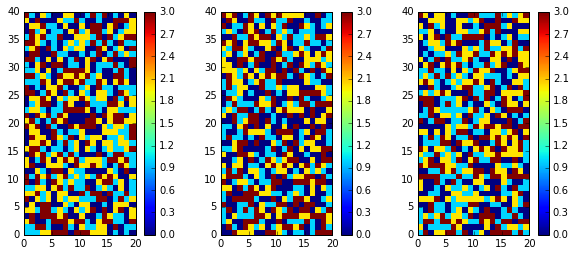

array([0, 1, 2, 3], dtype=int64)

In [2]:
from flopy.utils import read_zbarray

zone_file = os.path.join(loadpth, 'zonef_mlt')
zon = read_zbarray(zone_file)
nlay, nrow, ncol = zon.shape

fig = plt.figure(figsize=(10, 4))

for lay in range(nlay):
    ax = fig.add_subplot(1, nlay, lay+1)
    im = ax.pcolormesh(zon[lay, :, :])
    cbar = plt.colorbar(im)
    plt.gca().set_aspect('equal')
    
plt.show()
np.unique(zon)

### Extract Budget Information from ZoneBudget Object

At the core of the `ZoneBudget` object is a numpy structured array. The class provides some wrapper functions to help us interogate the array and save it to disk.

*Note that the `get_budget()` method returns a list of recarrays.*

In [3]:
# Create a ZoneBudget object and get the budget record array
zb = ZoneBudget(cbc_f, zon, kstpkper=(0, 1096))
zb.get_budget()[0]

(1097.0, 0, 1096, 'STORAGE_IN', 0.0, 0.0, 0.0)

In [4]:
# Get a list of the unique budget record names
zb.get_record_names()

array(['CONSTANT_HEAD_IN', 'CONSTANT_HEAD_OUT', 'DRAINS_IN', 'DRAINS_OUT',
       'IN-OUT', 'PERCENT_DISCREPANCY', 'RECHARGE_IN', 'RECHARGE_OUT',
       'STORAGE_IN', 'STORAGE_OUT', 'TOTAL_IN', 'TOTAL_OUT', 'WELLS_IN',
       'WELLS_OUT', 'ZONE_0_IN', 'ZONE_0_OUT', 'ZONE_1_IN', 'ZONE_1_OUT',
       'ZONE_2_IN', 'ZONE_2_OUT', 'ZONE_3_IN', 'ZONE_3_OUT'], 
      dtype='|S50')

In [5]:
# Look at a subset of fluxes
names = ['RECHARGE_IN', 'ZONE_1_IN', 'ZONE_3_IN']
zb.get_budget(names=names)

array([ (1097.0, 0, 1096, 'RECHARGE_IN', 1306.9328665733337, 1299.4646787643433, 1277.0601153373718),
       (1097.0, 0, 1096, 'ZONE_1_IN', 0.0, 3485.947250366211, 3202.0619506835938),
       (1097.0, 0, 1096, 'ZONE_3_IN', 3579.748610496521, 3084.417018890381, 0.0)], 
      dtype=[('totim', '<f4'), ('time_step', '<i4'), ('stress_period', '<i4'), ('name', 'S50'), ('ZONE_1', '<f8'), ('ZONE_2', '<f8'), ('ZONE_3', '<f8')])

In [6]:
# Look at fluxes in from zone 2
names = ['RECHARGE_IN', 'ZONE_1_IN', 'ZONE_3_IN']
zones = ['ZONE_2']
zb.get_budget(names=names, zones=zones)

array([(1097.0, 0, 1096, 'RECHARGE_IN', 1299.4646787643433),
       (1097.0, 0, 1096, 'ZONE_1_IN', 3485.947250366211),
       (1097.0, 0, 1096, 'ZONE_3_IN', 3084.417018890381)], 
      dtype=[('totim', '<f4'), ('time_step', '<i4'), ('stress_period', '<i4'), ('name', 'S50'), ('ZONE_2', '<f8')])

In [7]:
# Look at all of the mass-balance records
names = ['TOTAL_IN', 'TOTAL_OUT', 'IN-OUT', 'PERCENT_DISCREPANCY']
zb.get_budget(names=names)

array([ (1097.0, 0, 1096, 'TOTAL_IN', 13512.41998720169, 11405.733743667603, 11426.444146990776),
       (1097.0, 0, 1096, 'TOTAL_OUT', 13512.432970046997, 11405.73255777359, 11426.435069084167),
       (1097.0, 0, 1096, 'IN-OUT', -0.012982845306396484, 0.0011858940124511719, 0.009077906608581543),
       (1097.0, 0, 1096, 'PERCENT_DISCREPANCY', -9.608078406150355e-05, 1.0397350146459011e-05, 7.94465023225262e-05)], 
      dtype=[('totim', '<f4'), ('time_step', '<i4'), ('stress_period', '<i4'), ('name', 'S50'), ('ZONE_1', '<f8'), ('ZONE_2', '<f8'), ('ZONE_3', '<f8')])

### Convert Units
The `ZoneBudget` class supports the use of mathematical operators and returns a new copy of the object.

In [8]:
cmd = ZoneBudget(cbc_f, zon, kstpkper=(0, 0))
cfd = cmd / 35.3147
inyr = (cfd / (250 * 250)) * 365 * 12

cmdbud = cmd.get_budget()
cfdbud = cfd.get_budget()
inyrbud = inyr.get_budget()

names = ['RECHARGE_IN']
rowidx = np.in1d(cmdbud['name'], names)
colidx = 'ZONE_1'

print('{:,.1f} cubic meters/day'.format(cmdbud[rowidx][colidx][0]))
print('{:,.1f} cubic feet/day'.format(cfdbud[rowidx][colidx][0]))
print('{:,.1f} inches/year'.format(inyrbud[rowidx][colidx][0]))

1,580.5 cubic meters/day
44.8 cubic feet/day
3.1 inches/year


In [9]:
cmd is cfd

False

### Alias Names
A dictionary of {zone: "alias"} pairs can be passed to replace the typical "ZONE_X" fieldnames of the `ZoneBudget` structured array with more descriptive names.

In [10]:
aliases = {1: 'SURF', 2:'CONF', 3: 'UFA'}
zb = ZoneBudget(cbc_f, zon, totim=[1097.], aliases=aliases)
zb.get_budget()

array([(1097.0, 0, 1096, 'STORAGE_IN', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'CONSTANT_HEAD_IN', 0.0, 0.0, 86.14904022216797),
       (1097.0, 0, 1096, 'WELLS_IN', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'DRAINS_IN', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'RECHARGE_IN', 1306.9328665733337, 1299.4646787643433, 1277.0601153373718),
       (1097.0, 0, 1096, 'ZONE_0_IN', 4802.644836425781, 3535.9047956466675, 3882.708930850029),
       (1097.0, 0, 1096, 'SURF_IN', 0.0, 3485.947250366211, 3202.0619506835938),
       (1097.0, 0, 1096, 'CONF_IN', 3823.0936737060547, 0.0, 2978.4641098976135),
       (1097.0, 0, 1096, 'UFA_IN', 3579.748610496521, 3084.417018890381, 0.0),
       (1097.0, 0, 1096, 'TOTAL_IN', 13512.41998720169, 11405.733743667603, 11426.444146990776),
       (1097.0, 0, 1096, 'STORAGE_OUT', 0.0, 0.0, 0.0),
       (1097.0, 0, 1096, 'CONSTANT_HEAD_OUT', 101.54193305969238, 232.463134765625, 204.33761596679688),
       (1097.0, 0, 1096, 'WELLS_OUT', 2656.7999267578125, 0.0, 0.

### Return the Budgets as a Pandas DataFrame
Set `kstpkper` and `totim` keyword args to `None` (or omit) to return all times.
The `get_dataframes()` method will return a DataFrame multi-indexed on `totim` and `name`.

In [11]:
zon = np.ones((nlay, nrow, ncol), np.int)
zon[1, :, :] = 2
zon[2, :, :] = 3

aliases = {1: 'SURF', 2:'CONF', 3: 'UFA'}
zb = ZoneBudget(cbc_f, zon, kstpkper=None, totim=None, aliases=aliases)
df = zb.get_dataframes()
print(df.head())
print(df.tail())

                                SURF        CONF          UFA
totim name                                                   
1.0   CONF_IN            2218.183105    0.000000  1863.491943
      CONF_OUT           3752.850586    0.000000  1096.248657
      CONSTANT_HEAD_IN      0.000000    0.000000     0.000000
      CONSTANT_HEAD_OUT   911.639771  767.433716   767.249390
      DRAINS_IN             0.000000    0.000000     0.000000
                         SURF         CONF          UFA
totim  name                                            
1097.0 TOTAL_OUT  8328.821304  4869.630325  1725.220764
       UFA_IN        0.000000  1487.757812     0.000000
       UFA_OUT       0.000000  1639.001221     0.000000
       WELLS_IN      0.000000     0.000000     0.000000
       WELLS_OUT  4762.799942     0.000000     0.000000


Slice the multi-index dataframe to retrieve a subset of the budget

In [12]:
dateidx1 = 1092.
dateidx2 = 1097.
names = ['RECHARGE_IN', 'WELLS_OUT']
zones = ['SURF', 'CONF']
df.loc[(slice(dateidx1, dateidx2), names), :][zones]

SURF  CONF
totim  name                          
1092.0 RECHARGE_IN  6070.894356   0.0
       WELLS_OUT    2829.812140   0.0
1093.0 RECHARGE_IN  4240.286350   0.0
       WELLS_OUT    1930.483119   0.0
1094.0 RECHARGE_IN  4082.749522   0.0
       WELLS_OUT    1279.166363   0.0
1095.0 RECHARGE_IN  5053.779073   0.0
       WELLS_OUT     794.582903   0.0
1096.0 RECHARGE_IN  6168.920364   0.0
       WELLS_OUT    1373.782646   0.0
1097.0 RECHARGE_IN  5190.390527   0.0
       WELLS_OUT    4762.799942   0.0

Look at pumpage (`WELLS_OUT`) as a percentage of recharge (`RECHARGE_IN`)

In [13]:
dateidx1 = 1092.
dateidx2 = 1097.
zones = ['SURF']

# Pull out the individual records of interest
rech = df.loc[(slice(dateidx1, dateidx2), ['RECHARGE_IN']), :][zones]
pump = df.loc[(slice(dateidx1, dateidx2), ['WELLS_OUT']), :][zones]

# Remove the "record" field from the index so we can 
# take the difference of the two DataFrames
rech = rech.reset_index()
rech = rech.set_index(['totim'])
rech = rech[zones]
pump = pump.reset_index()
pump = pump.set_index(['totim'])
pump = pump[zones] * -1

# Compute pumping as a percentage of recharge
pump_as_pct = (pump / rech) * 100.
pump_as_pct

,SURF
totim,
1092.0,-46.612772
1093.0,-45.527188
1094.0,-31.331003
1095.0,-15.722549
1096.0,-22.269418
1097.0,-91.761880


In [14]:
# Use "slice(None)" to return all records
df.loc[(slice(dateidx1, dateidx2), slice(None)), :][zones]

SURF
totim  name                            
1092.0 CONF_IN              1723.474854
       CONF_OUT             3778.943359
       CONSTANT_HEAD_IN        8.232683
       CONSTANT_HEAD_OUT     717.869995
       DRAINS_IN               0.000000
       DRAINS_OUT             89.872526
       IN-OUT                 -0.046964
       PERCENT_DISCREPANCY    -0.000573
       RECHARGE_IN          6070.894356
       RECHARGE_OUT            0.000000
       STORAGE_IN            393.480278
       STORAGE_OUT           779.631114
       SURF_IN                 0.000000
       SURF_OUT                0.000000
       TOTAL_IN             8196.082171
       TOTAL_OUT            8196.129134
       UFA_IN                  0.000000
       UFA_OUT                 0.000000
       WELLS_IN                0.000000
       WELLS_OUT            2829.812140
1093.0 CONF_IN              1290.680176
       CONF_OUT             2774.201660
       CONSTANT_HEAD_IN       10.557623
       CONSTANT_HEAD_OUT     708.597717
       DRAINS_IN               0.000000
       DRAINS_OUT            115.761371
       IN-OUT                 -0.023209
       PERCENT_DISCREPANCY    -0.000377
       RECHARGE_IN          4240.286350
       RECHARGE_OUT            0.000000
...                                 ...
1096.0 STORAGE_IN            105.632975
       STORAGE_OUT           960.740421
       SURF_IN                 0.000000
       SURF_OUT                0.000000
       TOTAL_IN             7439.031176
       TOTAL_OUT            7439.271643
       UFA_IN                  0.000000
       UFA_OUT                 0.000000
       WELLS_IN                0.000000
       WELLS_OUT            1373.782646
1097.0 CONF_IN              2993.026611
       CONF_OUT             3295.723145
       CONSTANT_HEAD_IN      145.417542
       CONSTANT_HEAD_OUT     270.298218
       DRAINS_IN               0.000000
       DRAINS_OUT              0.000000
       IN-OUT                  0.013376
       PERCENT_DISCREPANCY     0.000161
       RECHARGE_IN          5190.390527
       RECHARGE_OUT            0.000000
       STORAGE_IN              0.000000
       STORAGE_OUT             0.000000
       SURF_IN                 0.000000
       SURF_OUT                0.000000
       TOTAL_IN             8328.834680
       TOTAL_OUT            8328.821304
       UFA_IN                  0.000000
       UFA_OUT                 0.000000
       WELLS_IN                0.000000
       WELLS_OUT            4762.799942

[120 rows x 1 columns]

In [15]:
# Or all times
df.loc[(slice(None), names), :][zones]

SURF
totim  name                    
1.0    RECHARGE_IN  6276.861916
       WELLS_OUT       0.000000
2.0    RECHARGE_IN  6428.198547
       WELLS_OUT    1302.403252
3.0    RECHARGE_IN  5397.295954
       WELLS_OUT    1618.676394
4.0    RECHARGE_IN  5931.377501
       WELLS_OUT    1498.694752
5.0    RECHARGE_IN  8378.571858
       WELLS_OUT    3119.501953
6.0    RECHARGE_IN  7390.347524
       WELLS_OUT    2243.920387
7.0    RECHARGE_IN  5168.854048
       WELLS_OUT    2350.731133
8.0    RECHARGE_IN  6098.494825
       WELLS_OUT    3856.392490
9.0    RECHARGE_IN  6478.777094
       WELLS_OUT    5265.850121
10.0   RECHARGE_IN  5944.929848
       WELLS_OUT    4830.996731
11.0   RECHARGE_IN  5213.968110
       WELLS_OUT    3962.774696
12.0   RECHARGE_IN  5336.513877
       WELLS_OUT    1361.825874
13.0   RECHARGE_IN  4734.848230
       WELLS_OUT    4300.694023
14.0   RECHARGE_IN  5080.193455
       WELLS_OUT    1994.616829
15.0   RECHARGE_IN  5430.782120
       WELLS_OUT    1721.189125
...                         ...
1083.0 RECHARGE_IN  7740.506029
       WELLS_OUT    5042.142624
1084.0 RECHARGE_IN  8045.819240
       WELLS_OUT    5450.098251
1085.0 RECHARGE_IN  8445.465980
       WELLS_OUT    6776.316984
1086.0 RECHARGE_IN  8063.489585
       WELLS_OUT    3623.597162
1087.0 RECHARGE_IN  6653.122292
       WELLS_OUT    9296.972047
1088.0 RECHARGE_IN  6050.643716
       WELLS_OUT    3753.738119
1089.0 RECHARGE_IN  5276.522524
       WELLS_OUT    2676.539921
1090.0 RECHARGE_IN  5734.640808
       WELLS_OUT    5745.907732
1091.0 RECHARGE_IN  6955.568213
       WELLS_OUT    2874.090935
1092.0 RECHARGE_IN  6070.894356
       WELLS_OUT    2829.812140
1093.0 RECHARGE_IN  4240.286350
       WELLS_OUT    1930.483119
1094.0 RECHARGE_IN  4082.749522
       WELLS_OUT    1279.166363
1095.0 RECHARGE_IN  5053.779073
       WELLS_OUT     794.582903
1096.0 RECHARGE_IN  6168.920364
       WELLS_OUT    1373.782646
1097.0 RECHARGE_IN  5190.390527
       WELLS_OUT    4762.799942

[2194 rows x 1 columns]

Pass `start_datetime` and `timeunit` keyword arguments to return a dataframe with a datetime multi-index

In [16]:
df = zb.get_dataframes(start_datetime='1970-01-01', timeunit='D')
dateidx1 = pd.Timestamp('1972-12-01')
dateidx2 = pd.Timestamp('1972-12-06')
names = ['RECHARGE_IN', 'WELLS_OUT']
zones = ['SURF', 'CONF']
df.loc[(slice(dateidx1, dateidx2), names), :][zones]

SURF  CONF
datetime   name                          
1972-12-01 RECHARGE_IN  8331.025639   0.0
           WELLS_OUT    5903.374154   0.0
1972-12-02 RECHARGE_IN  7553.003516   0.0
           WELLS_OUT    1705.206116   0.0
1972-12-03 RECHARGE_IN  5630.780802   0.0
           WELLS_OUT    2157.596333   0.0
1972-12-04 RECHARGE_IN  6026.509709   0.0
           WELLS_OUT    5252.826000   0.0
1972-12-05 RECHARGE_IN  7979.104075   0.0
           WELLS_OUT    6158.951546   0.0
1972-12-06 RECHARGE_IN  8254.627576   0.0
           WELLS_OUT    2989.254021   0.0

Pass `index_key` to indicate which fields to use in the multi-index (defualt is "totim"; valid keys are "totim" and "kstpkper")

In [17]:
df = zb.get_dataframes(index_key='kstpkper')
df.head()

SURF        CONF  \
time_step stress_period name                                         
0         0             CONF_IN            2218.183105    0.000000   
                        CONF_OUT           3752.850586    0.000000   
                        CONSTANT_HEAD_IN      0.000000    0.000000   
                        CONSTANT_HEAD_OUT   911.639771  767.433716   
                        DRAINS_IN             0.000000    0.000000   

                                                   UFA  
time_step stress_period name                            
0         0             CONF_IN            1863.491943  
                        CONF_OUT           1096.248657  
                        CONSTANT_HEAD_IN      0.000000  
                        CONSTANT_HEAD_OUT   767.249390  
                        DRAINS_IN             0.000000

### Write Budget Output to CSV

We can write the resulting recarray to a csv file with the `.to_csv()` method of the `ZoneBudget` object.

In [18]:
zb = ZoneBudget(cbc_f, zon, kstpkper=[(0, 0), (0, 1096)])
zb.to_csv(os.path.join(loadpth, 'zonbud.csv'))

# Read the file in to see the contents
fname = os.path.join(loadpth, 'zonbud.csv')
try:
    import pandas as pd
    print(pd.read_csv(fname).to_string(index=False))
except:
    with open(fname, 'r') as f:
        for line in f.readlines():
            print('\t'.join(line.split(',')))

totim  time_step  stress_period                 name       ZONE_1       ZONE_2       ZONE_3
   1.0          0              0           STORAGE_IN     0.000000     0.000000     0.000000
   1.0          0              0     CONSTANT_HEAD_IN     0.000000     0.000000     0.000000
   1.0          0              0             WELLS_IN     0.000000     0.000000     0.000000
   1.0          0              0            DRAINS_IN     0.000000     0.000000     0.000000
   1.0          0              0          RECHARGE_IN  6276.861916     0.000000     0.000000
   1.0          0              0            ZONE_1_IN     0.000000  3752.850586     0.000000
   1.0          0              0            ZONE_2_IN  2218.183105     0.000000  1863.491943
   1.0          0              0            ZONE_3_IN     0.000000  1096.248657     0.000000
   1.0          0              0             TOTAL_IN  8495.045021  4849.099243  1863.491943
   1.0          0              0          STORAGE_OUT     0.000000     